### Optimal control of the noisy phenomenological models, e.g. the FHN model
This notebook shows how to compute the optimal control signal for the noisy FHN model for a simple example task. Can be run analogously for the Hopf model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. In a deterministic system, the optimal control signal should converge to the input signal. In a noisy system, this should not be possible precisely, but only approximately, depending on the noise strength.

In [2]:
# We import the model
model = FHNModel()
# model = HopfModel()
model.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 40.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.
y_init = 0.
model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

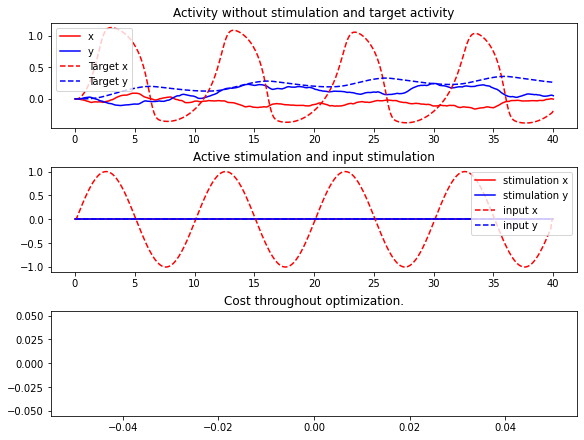

In [3]:
# We set the stimulus in x and y variables, and run the simulation in a noise-free system
model.params["x_ext"] = input
model.params["y_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation with noise
# Change sigma_ou_parameter to adjust the noise strength
model.params['sigma_ou'] = 0.1
model.params['tau_ou'] = 1.
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

The target is a periodic oscillation of x and y variable (computed in deterministic, noise-free system).

The noisy, undistrubed system fluctuates around zero.

For the optimization, you can now set several new parameters:
- M: the number of noise realizations that the algorithm averages over. Default=1
- M_validation: the number of noise realization the final cost is computed from. Default=1000
- validate_per_step: If True, the cost for each step is computed averaging over M_validation instead of M realizations, this takes much longer. Default=False
- method: determines, how the noise averages are computed. Results may vary for different methods depending on the specific task. Choose from ['3']. Default='3'

Please note:
- higher number of iterations does not promise better results for computations in noisy systems. The cost will level off at some iteration number, and start increasing again afterwards. Make sure not to perform too many iterations.
- M, M_validation should increase with sigma_ou model parameter
- validate_per_step does not impact the control result

Let's optimize with the following parameters: M=20, method='3', iterations=100

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 97.57150928535303
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  0.625


ERROR:root:nan in model output!


diverging model output, decrease step size to  0.15625


ERROR:root:nan in model output!


Mean cost in iteration 10: 92.34478838801422
diverging model output, decrease step size to  0.0390625
Mean cost in iteration 20: 58.97932484053209
Mean cost in iteration 30: 51.71113768025852
Mean cost in iteration 40: 55.538204071771474
Mean cost in iteration 50: 44.672453199313374
Mean cost in iteration 60: 42.44623291947449
Mean cost in iteration 70: 43.258266843866416
Mean cost in iteration 80: 39.14394976846711
Mean cost in iteration 90: 39.749178059179776
Mean cost in iteration 100: 36.47942569524502
Minimal cost found at iteration 86
Final cost validated with 500 noise realizations : 36.93857159870287


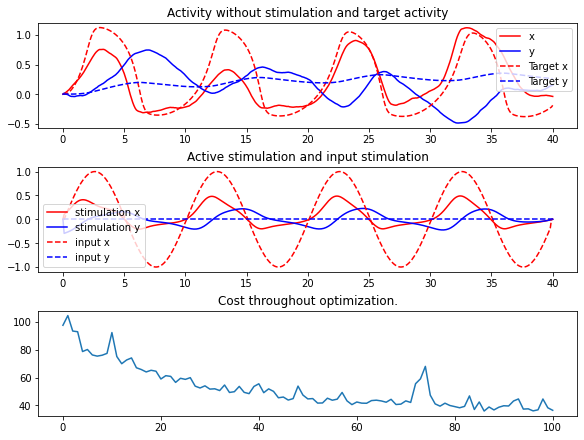

In [15]:


# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
                              M=20, M_validation=500, validate_per_step=True)

#model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
#                              M=20, M_validation=500, validate_per_step=True)

# We run 100 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)


Let's do the same thing with different parameters: M=100, method='3', iterations=30

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 98.1393223831105
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.15625
Mean cost in iteration 5: 75.48136085066727
Mean cost in iteration 10: 61.16824619805841
Mean cost in iteration 15: 54.22270437995599
Mean cost in iteration 20: 49.49199087835544
Mean cost in iteration 25: 50.373471699374065
Mean cost in iteration 30: 45.598492260955126
Mean cost in iteration 35: 46.2097487649941
Mean cost in iteration 40: 43.66716287765782
Mean cost in iteration 45: 44.22696117840781
Mean cost in iteration 50: 42.173760821464604
Minimal cost found at iteration 47
Final cost validated with 500 noise realizations : 40.82513194745294


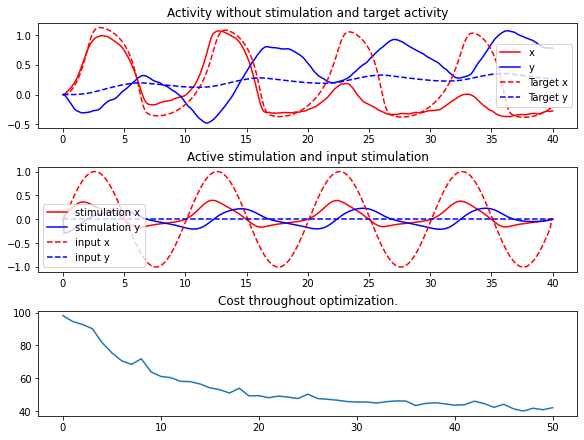

In [16]:
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=np.arange(0,51,5),
                              M=100, M_validation=500, validate_per_step=True)

# model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=np.arange(0,51,5),
#                              M=100, M_validation=500, validate_per_step=True)

model_controlled.optimize(50)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Apparently, for this problem, the first approach is more efficient.

The larger M leads to a more steady decrease in cost in the second approach.

### Network case

Let us know study a simple 2-node network of noisy FHN oscillators. Each population in each node incorporates noise.We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

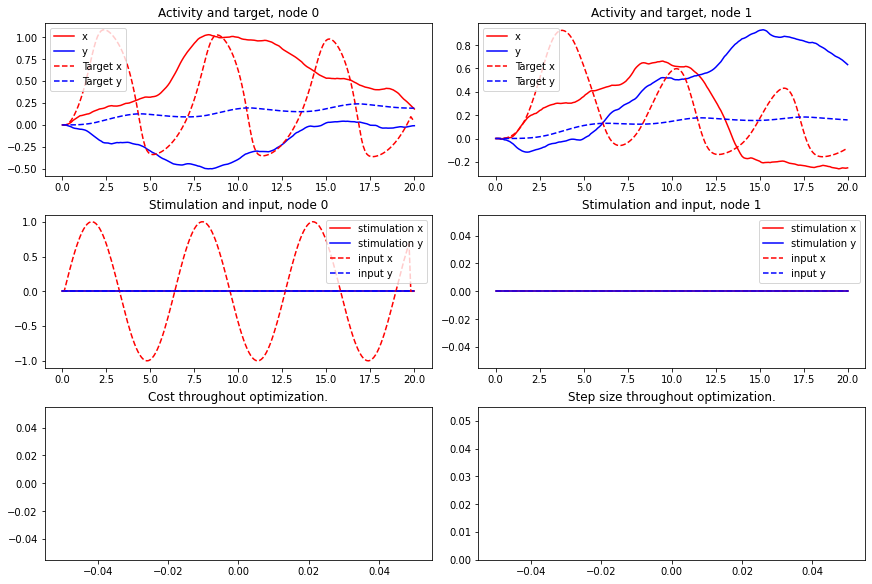

In [17]:
cmat = np.array( [[0., 0.], [1., 0.]] )  # diagonal elements are zero, connection stregth is 1 (0.) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = FHNModel(Cmat=cmat, Dmat=dmat)
#model = HopfModel(Cmat=cmat, Dmat=dmat)

model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

# noise free target
model.params['sigma_ou'] = 0.

duration = 20.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["xs_init"] = np.vstack( [x_init, x_init] )
model.params["ys_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params['sigma_ou'] = 0.1
model.params['tau_ou'] = 1.
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Let's optimize with the following parameters: M=20, method='3', iterations=100

In [18]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,1] = 1. # only measure in y-channel in node 1

model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model_controlled = oc_fhn.OcFhn(model,
                              target,
                              w_p=1,
                              w_2=0,
                              print_array=np.arange(0,101,10),
                              control_matrix=control_mat,
                              precision_matrix=prec_mat,
                              M=20,
                              M_validation=500,
                              validate_per_step=True)

#model_controlled = oc_hopf.OcHopf(model,
#                              target,
#                              w_p=1,
#                              w_2=0,
#                              print_array=np.arange(0,101,10),
#                              control_matrix=control_mat,
#                              precision_matrix=prec_mat,
#                              M=20,
#                              M_validation=500,
#                              validate_per_step=True)

model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a noisy system
Mean cost in iteration 0: 4.912722139463288
Mean cost in iteration 10: 4.403918328550476
Mean cost in iteration 20: 4.595548904687723
Mean cost in iteration 30: 4.258914632804607
Mean cost in iteration 40: 4.189357488597016
Mean cost in iteration 50: 3.808189760813331
Mean cost in iteration 60: 3.7420669728197513


Let's do the same thing with different parameters: M=100, method='3', iterations=50

Compute control for a noisy system
Mean cost in iteration 5: 4.592717038110373
Mean cost in iteration 10: 4.070122192639255
Mean cost in iteration 15: 4.791994653220183
Mean cost in iteration 20: 3.90123203786211
Mean cost in iteration 25: 4.281538105316256
Mean cost in iteration 30: 3.9351638255619967
Final cost validated with 500 noise realizations : 3.962777228987637


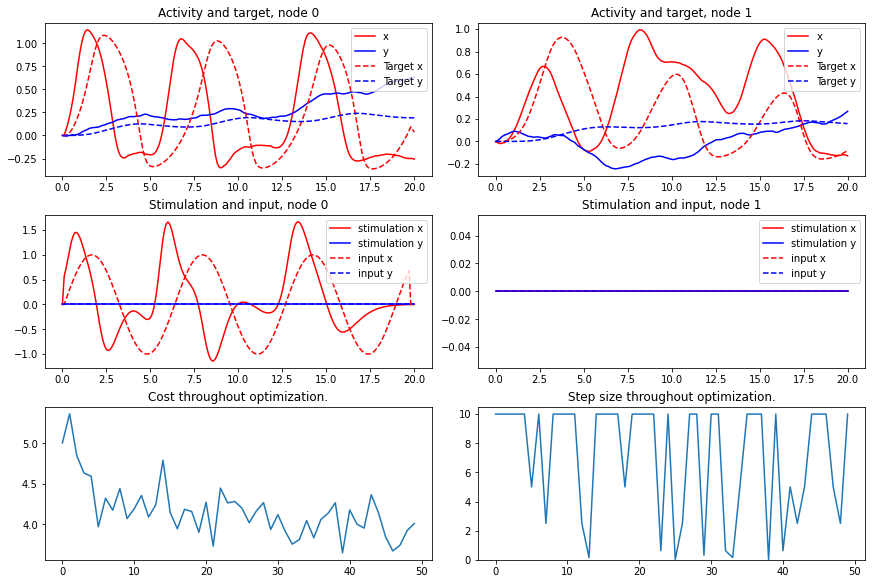

In [ ]:
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model_controlled = oc_fhn.OcFhn(model,
                              target,
                              w_p=1,
                              w_2=0,
                              print_array=np.arange(0,51,5),
                              control_matrix=control_mat,
                              precision_matrix=prec_mat,
                              M=100,
                              M_validation=500,
                              validate_per_step=True)

# model_controlled = oc_hopf.OcHopf(model,
#                              target,
#                              w_p=1,
#                              w_2=0,
#                              print_array=np.arange(0,31,5),
#                              control_matrix=control_mat,
#                              precision_matrix=prec_mat,
#                              M=100,
#                              M_validation=500,
#                              validate_per_step=True)

model_controlled.optimize(50)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

This time, the two approaches seem similarly successful.